**Tip:** Enable the GPU if you're running this notebook in [Colab](https://colab.research.google.com) 

* *Edit -> Notebook settings -> Hardware accellerator -> GPU*.

## Image Classification using a CNN

In this notebook, we will train a CNN-based image classifier to classify a couple thousand images of cats and dogs, loaded from a directory on disk.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download the dataset

We will download a zip of 2,000 pictures of cats and dogs in JPEG format (a subset of this [dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765) from Microsoft Research).

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-02-10 04:29:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 2607:f8b0:4001:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   148MB/s    in 0.4s    

2019-02-10 04:29:44 (148 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Extract the zip.

In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The dataset we downloaded has following directory structure. 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

You can also explore these directories using shell commands.

In [4]:
!ls '/tmp/cats_and_dogs_filtered'
!ls '/tmp/cats_and_dogs_filtered/train/dogs'

train  validation  vectorize.py
dog.0.jpg    dog.250.jpg  dog.400.jpg  dog.551.jpg  dog.701.jpg  dog.852.jpg
dog.100.jpg  dog.251.jpg  dog.401.jpg  dog.552.jpg  dog.702.jpg  dog.853.jpg
dog.101.jpg  dog.252.jpg  dog.402.jpg  dog.553.jpg  dog.703.jpg  dog.854.jpg
dog.102.jpg  dog.253.jpg  dog.403.jpg  dog.554.jpg  dog.704.jpg  dog.855.jpg
dog.103.jpg  dog.254.jpg  dog.404.jpg  dog.555.jpg  dog.705.jpg  dog.856.jpg
dog.104.jpg  dog.255.jpg  dog.405.jpg  dog.556.jpg  dog.706.jpg  dog.857.jpg
dog.105.jpg  dog.256.jpg  dog.406.jpg  dog.557.jpg  dog.707.jpg  dog.858.jpg
dog.106.jpg  dog.257.jpg  dog.407.jpg  dog.558.jpg  dog.708.jpg  dog.859.jpg
dog.107.jpg  dog.258.jpg  dog.408.jpg  dog.559.jpg  dog.709.jpg  dog.85.jpg
dog.108.jpg  dog.259.jpg  dog.409.jpg  dog.55.jpg   dog.70.jpg	 dog.860.jpg
dog.109.jpg  dog.25.jpg   dog.40.jpg   dog.560.jpg  dog.710.jpg  dog.861.jpg
dog.10.jpg   dog.260.jpg  dog.410.jpg  dog.561.jpg  dog.711.jpg  dog.862.jpg
dog.110.jpg  dog.261.jpg  dog.411.jpg  dog.562

These variables will keep track of the directories for the training and validation sets.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Explore the data

Let's see how many image we have in each directory.

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('Training cat images:', num_cats_tr)
print('Training dog images:', num_dogs_tr)

print('Validation cat images:', num_cats_val)
print('Validation dog images:', num_dogs_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Reading images off disk

We will use a couple handy utilities to read the images off disk, and to resize them to a consistent shape (and in the next notebook, to augment the training data). We will:

* Read the images from the disk
* Decode the JPGs into arrays of floating point values.
* Resize each image to be 150x150 pixels (our CNN requires all images to be the same shape).
* Rescale the pixel values from 0 and 255 to values between 0 and 1.

Fortunately, all these tasks can be done using a single class. Not only can it read images and preprocess them, but it will also set up generators that will turn these images into batches, which will be helpful when we train our network.

We can set up this using a couple of lines of code.

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 150 
BATCH_SIZE = 32

These objects will be used to rescale images as they're read of disk. In the next notebook, we'll use them for data augmentation as well.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

Next, the `flow_from_directory` method will load images from disk and resize them into the required dimensions.

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


Let's take a look at some of the images we've loaded. 

* The *next* function returns a batch from the dataset. 
* The return values are in the form of (images, labels). 

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen) 

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

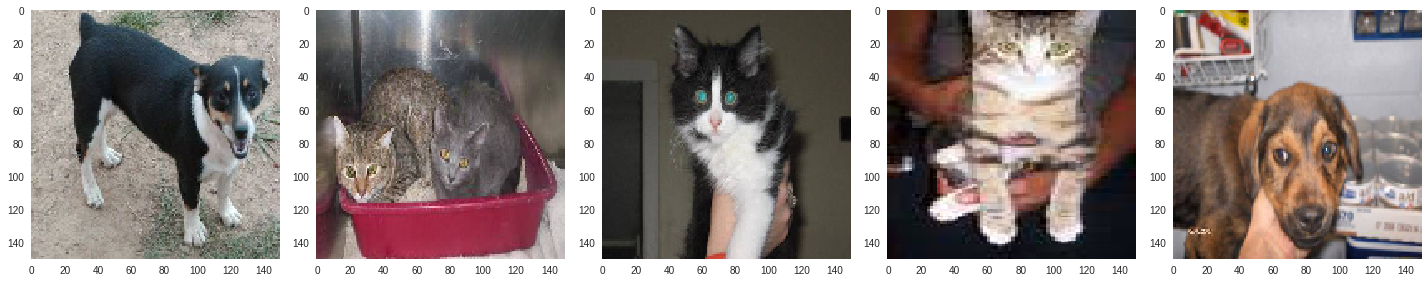

In [14]:
plotImages(sample_training_images[:5])

## Create and compile the model

We'll use a few Conv / MaxPool layers for our base, followed by one or more Dense layers.
* See this [doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) for a description of the parameters.

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv

Let's see a summary of our model. Notice the majority of the parameters are in the Dense layer.

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Train the model using fit_generator
We will use the *fit_generator* function instead of *fit*, which you've seen before. The first argument is a Python generator that will yield batches of data and labels indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know how many examples to draw from the generator before declaring an epoch over. We pass two parameters to specify this (steps_per_epoch and validation_steps).

In [0]:
EPOCHS = 20

In [18]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
63/63 [==============================] - 13s 212ms/step - loss: 0.6952 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/20
63/63 [==============================] - 11s 180ms/step - loss: 0.6936 - acc: 0.5045 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 3/20
63/63 [==============================] - 11s 180ms/step - loss: 0.6935 - acc: 0.5020 - val_loss: 0.6861 - val_acc: 0.5120
Epoch 4/20
63/63 [==============================] - 11s 181ms/step - loss: 0.6764 - acc: 0.5695 - val_loss: 0.6485 - val_acc: 0.6090
Epoch 5/20
63/63 [==============================] - 11s 181ms/step - loss: 0.6441 - acc: 0.6125 - val_loss: 0.6607 - val_acc: 0.6130
Epoch 6/20
63/63 [==============================] - 11s 181ms/step - loss: 0.6105 - acc: 0.6775 - val_loss: 0.6043 - val_acc: 0.6670
Epoch 7/20
63/63 [==============================] - 11s 180ms/step - loss: 0.5405 - acc: 0.7245 - val_loss: 0.5700 - val_acc: 0.7090
Epoch 8/20
63/63 [===

### Results
Let's see how we did.

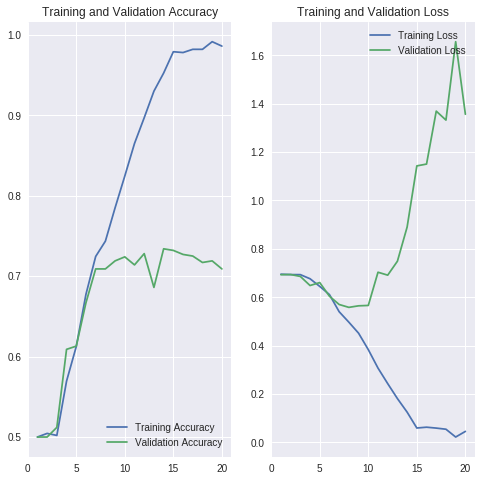

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This network has effectively memorized the training data (overfitting occurs quickly). In the next notebook, we'll leverage data augmentation and dropout to improve that.